# This notebook shows the application of our method to estimate the magnetization direction of different synthetic sources by using the robust approach. These sources are: 1) two spheres; 2) cube and sphere; 3) cube similiar to that presented by Ellis, Wet and Macleod (2012); and 4) two prisms similar to that presented by Lelièvre and Oldenburg (2009).

References

* Lelièvre, P. G. and D. Oldenburg, 2009, A 3D total magnetization inversion 
    applicable when significant, complicated remanence is present. Geophysics,
    74(3), L21–L30, doi: [10.1190/1.3103249](http://dx.doi.org/10.1190/1.3103249)

* Ellis, R. G., B. Wet and I. N. Macleod, 2012, Inversion of magnetic data from 
    remanent and induced sources: 22nd International geophysical conference and 
    exhibition, ASEG, Expanded Abrastracts, 1-4, [link](http://www.geosoft.com/media/uploads/resources/technical-papers/magnetization_vector_inversion_mvi.pdf).

In [1]:
#source1: https://neuronvisio.readthedocs.org/en/latest/gettingstarted.html#troubleshooting
#source2: http://ipython.org/ipython-doc/dev/interactive/reference.html#pyqt-and-pyside

import sip
sip.setapi('QString', 2)
sip.setapi('QVariant', 2)

In [2]:
%matplotlib inline
import numpy
import scipy
from scipy import sparse
from IPython.display import Image

from fatiando import mesher, gridder, gravmag
from fatiando.gravmag import sphere, prism, polyprism, fourier
from fatiando.gravmag.euler import Classic, ExpandingWindow
from fatiando.utils import ang2vec, vec2ang, contaminate
from fatiando.vis import mpl, myv
from fatiando.gravmag.magdir import DipoleMagDir

In [3]:
mpl.rcParams['font.size'] = 14

### These numerical tests use the open-source Python toolkit [Fatiando a Terra](http://fatiando.org/)

In [4]:
def uncertainty_L1(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L1 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1.0/w
    W = scipy.sparse.diags(w, 0)
    H = numpy.linalg.inv((solver.jacobian(p=None).T*W).dot(solver.jacobian(p=None))).dot(solver.jacobian(p=None).T)
    H = H*W
    dp = numpy.sqrt(numpy.diagonal((uncertainty_data**2)*H.dot(H.T)))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

## (Test L1-1) Estimation of the magnetization direction of two spherical sources with known centers

c:\Anaconda\lib\site-packages\traits\has_traits.py:1766: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


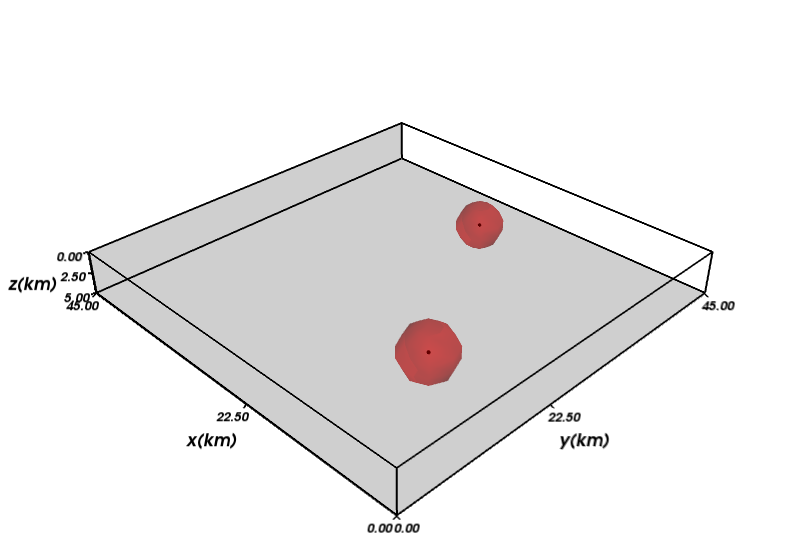

In [5]:
# Make noise-corrupted synthetic data
inc, dec = -9.5, -13.0 # inclination and declination of the Geomagnetic Field
incs, decs = -40.0, -13.0 # inclination and declination of the bodies
model = [mesher.Sphere(11500, 15400, 3200, 3200, 
                       {'magnetization': ang2vec(3.5, incs, decs)}),
         mesher.Sphere(23830, 36350, 2970, 2700, 
                       {'magnetization': ang2vec(12.1, incs, decs)})]
area = [0, 45000, 0, 45000]
x, y, z = gridder.scatter(area, 8281, z=-150, seed=0)
uncertainty_data = 5.0 # nT
tf = contaminate(gravmag.sphere.tf(x, y, z, model, inc, dec), uncertainty_data)

# Give the centers of the dipoles
centers = [[11500, 15400, 3200], [23830, 36350, 2970]]

scene = myv.figure(size=(800,600))
myv.points(centers, size=200.)
for i, d in enumerate(model):
    myv.points([[d.x, d.y, d.z]], color=(1, 0, 0), size=d.radius, opacity=0.4)
bounds = area + [0, 5000]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-42326.966066038498, -40997.36957106967, -54908.390750413615]
scene.scene.camera.focal_point = [22500.000000000036, 22500.000000000015, 3200.000000000096]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.38139100640620682, 0.38127500921456181, -0.84212247777915095]
scene.scene.camera.clipping_range = [49920.595712440787, 180815.4251990678]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('spheres_known_centers_L1.png')
myv.show()
Image(filename='spheres_known_centers_L1.png')

### This Figure shows the synthetic spheres and their true centers (black points).

In [6]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
for i in range(solver.ndipoles):
    print '%12.5e %12.5e' % (incs, decs)
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-4.00000e+01 -1.30000e+01
-4.00000e+01 -1.30000e+01
Estimated
-3.99770e+01 -1.29033e+01
-4.00092e+01 -1.30306e+01
Uncertainties
 7.42364e-06  3.24291e-05
 2.72464e-03  5.69465e-03


c:\Anaconda\lib\site-packages\matplotlib\contour.py:381: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)
c:\Anaconda\lib\site-packages\matplotlib\text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
c:\Anaconda\lib\site-packages\matplotlib\text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


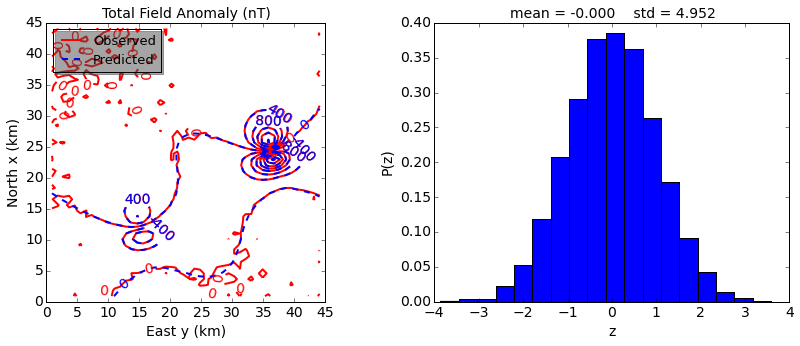

In [7]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', 
            label='Predicted', clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
# Each residual is subtracted from the mean and the resulting 
# difference is divided by the standard deviation
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), 
                                                              fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('spheres_known_centers_L1_fit.png')
Image(filename='spheres_known_centers_L1_fit.png')
mpl.show()

## (Test L1-2) Estimation of the magnetization direction of a sphere and cube with known centers

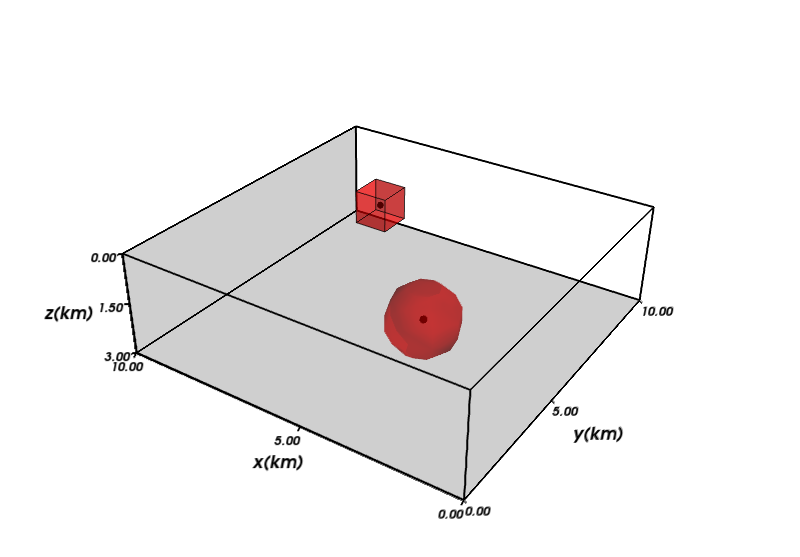

In [8]:
# Make noise-corrupted synthetic data
inc, dec = -10.0, -15.0 # inclination and declination of the Geomagnetic Field
incs = [-20.0, 30.0]
decs = [-10.0, -40.0]
ints = [6.0, 6.0]
dipole = mesher.Sphere(3000, 3000, 1000, 1000, 
                       {'magnetization': ang2vec(ints[0], incs[0], decs[0])})
prism = mesher.Prism(6500, 7500, 6500, 7500, 200, 1200, 
                       {'magnetization': ang2vec(ints[1], incs[1], decs[1])})
area = [0, 10000, 0, 10000]
x, y, z = gridder.scatter(area, 10000, z=-150, seed=0)
tf = gravmag.sphere.tf(x, y, z, [dipole], inc, dec) + gravmag.prism.tf(x, y, z, [prism], inc, dec)
uncertainty_data = 5.0 # nT
tf = contaminate(tf, uncertainty_data) # Gaussian noise with zero mean and standard deviation 5.0 nT

# Give the centers of the synthetic bodies
centers = [[3000, 3000, 1000], [7000, 7000, 700]] # list of Cartesian x, y, z coordinates

scene = myv.figure(size=(800,600))
myv.points(centers, size=100.)
myv.prisms([prism], linewidth=1, color=(1, 0, 0), opacity=0.5)
myv.points([[dipole.x, dipole.y, dipole.z]], color=(1, 0, 0), size=dipole.radius, opacity=0.5)
bounds = area + [0, 3000]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-8074.8174870455587, -15111.695190949795, -12802.708939521674]
scene.scene.camera.focal_point = [5000.0000000000173, 5000.0000000000218, 1500.0000000000127]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.2894571115937859, 0.42260310974121879, -0.85884875978535002]
scene.scene.camera.clipping_range = [14297.219095006843, 45154.738489868898]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('sph_cube_known_centers_L1.png')
myv.show()
Image(filename='sph_cube_known_centers_L1.png')

### This Figure shows the synthetic bodies (sphere and cube) and their true centers (black points).

In [9]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
for i in range(len(incs)):
    print '%12.5e %12.5e' % (incs[i], decs[i])
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-2.00000e+01 -1.00000e+01
 3.00000e+01 -4.00000e+01
Estimated
-1.99857e+01 -1.00054e+01
 3.04496e+01 -4.02332e+01
Uncertainties
 9.98201e-04  4.31551e-03
 3.15943e-02  6.56926e-02


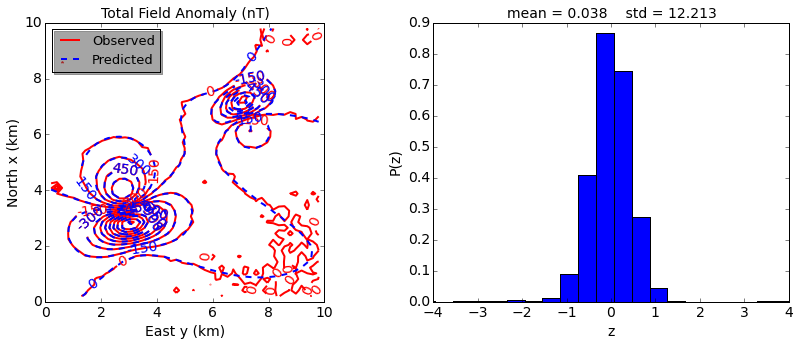

In [10]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('sph_cube_known_centers_L1_fit.png')
Image(filename='sph_cube_known_centers_L1_fit.png')
mpl.show()

## (Test L1-3) Estimation of the magnetization direction of a sphere and cube with estimated centers. The centers of the sources are estimated by using an Euler Deconvolution with [expanding window strategy](http://fatiando.readthedocs.org/en/latest/api/gravmag.euler.html#fatiando.gravmag.euler.ExpandingWindow)

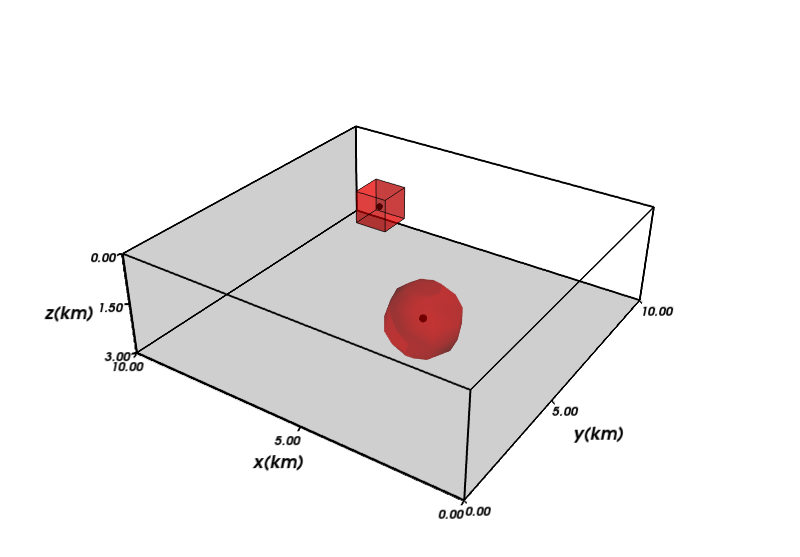

In [11]:
# Make noise-corrupted synthetic data
incs = [-20.0, 30.0]
decs = [-10.0, -40.0]
ints = [6.0, 6.0]
dipole = mesher.Sphere(3000, 3000, 1000, 1000, 
                       {'magnetization': ang2vec(ints[0], incs[0], decs[0])})
prism = mesher.Prism(6500, 7500, 6500, 7500, 200, 1200, 
                       {'magnetization': ang2vec(ints[1], incs[1], decs[1])})
area = [0, 10000, 0, 10000]
shape = (100,100)
x, y, z = gridder.regular(area, shape, z=-350)
tf = gravmag.sphere.tf(x, y, z, [dipole], inc, dec) + gravmag.prism.tf(x, y, z, [prism], inc, dec)
uncertainty_data = 5.0 # nT
tf = contaminate(tf, uncertainty_data) # Gaussian noise with zero mean and standard deviation 5.0 nT

# Estimate the centers with Euler deconvolution
xderiv = gravmag.fourier.derivx(x, y, tf, shape)
yderiv = gravmag.fourier.derivy(x, y, tf, shape)
zderiv = gravmag.fourier.derivz(x, y, tf, shape)

# Pick the centers of the expanding windows interactively
#mpl.figure()
#mpl.suptitle('Pick the centers of the expanding windows')
#mpl.axis('scaled')
#mpl.contourf(y, x, tf, shape, 50)
#mpl.colorbar()
#wcenters = mpl.pick_points(area, mpl.gca(), xy2ne=True)

# Centers of the expanding windows
wcenters = [[ 3404.81171548,  2918.41004184],
            [ 7144.35146444,  7024.05857741]]

euler = Classic(x, y, z, tf, xderiv, yderiv, zderiv, 3)
sizes = numpy.linspace(200, 3000, 30)
results = [ExpandingWindow(euler, c, sizes).fit() for c in wcenters]

scene = myv.figure(size=(800,600))
centers = [r.estimate_ for r in results]
myv.points(centers, size=100.)
myv.prisms([prism], linewidth=1, color=(1, 0, 0), opacity=0.5)
myv.points([[dipole.x, dipole.y, dipole.z]], color=(1, 0, 0), size=dipole.radius, opacity=0.5)
bounds = area + [0, 3000]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-8074.8174870455587, -15111.695190949795, -12802.708939521674]
scene.scene.camera.focal_point = [5000.0000000000173, 5000.0000000000218, 1500.0000000000127]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.2894571115937859, 0.42260310974121879, -0.85884875978535002]
scene.scene.camera.clipping_range = [14297.219095006843, 45154.738489868898]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('sph_cube_euler_centers_L1.png')
myv.show()
Image(filename='sph_cube_euler_centers_L1.png')

### This Figure shows the synthetic bodies (sphere and cube) and their estimated centers (black points).

In [12]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
for i in range(solver.ndipoles):
    print '%12.5e %12.5e' % (incs[i], decs[i])
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-2.00000e+01 -1.00000e+01
 3.00000e+01 -4.00000e+01
Estimated
-2.10311e+01 -1.00681e+01
 2.75411e+01 -3.77133e+01
Uncertainties
 2.62292e-04  9.62817e-04
 1.61954e-02  3.10293e-02


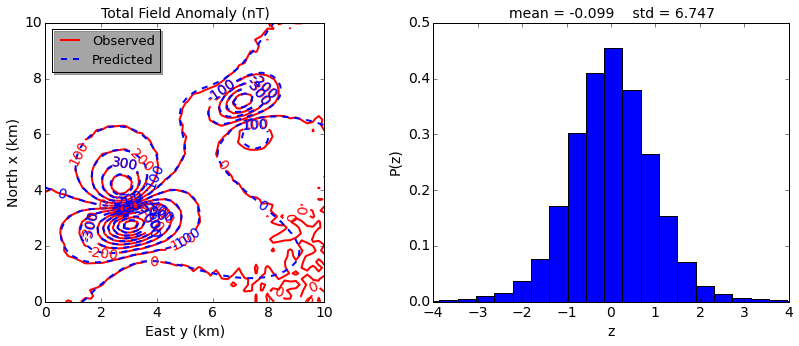

In [13]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('sph_cube_euler_centers_L1_fit.png')
Image(filename='sph_cube_euler_centers_L1_fit.png')
mpl.show()

## (Test L1-4) Test simulating the presence of a base level in the data used to determine the magnetization direction of a sphere and cube with estimated centers. The centers of the sources are estimated by using an Euler Deconvolution with [expanding window strategy](http://fatiando.readthedocs.org/en/latest/api/gravmag.euler.html#fatiando.gravmag.euler.ExpandingWindow)

This test simulates a superposed constant regional field equal to 50 nT. The result shows that this regional field does not lead to wrong estimates of the centers of the sources by Euler Deconvolution. The Euler Deconvolution deals with this regional field by estimating a non-null base level. On the other hand, this result shows that this regional field leads to poorer estimated magnetization directions as compared with that ones previously obtained (Test L1-3).

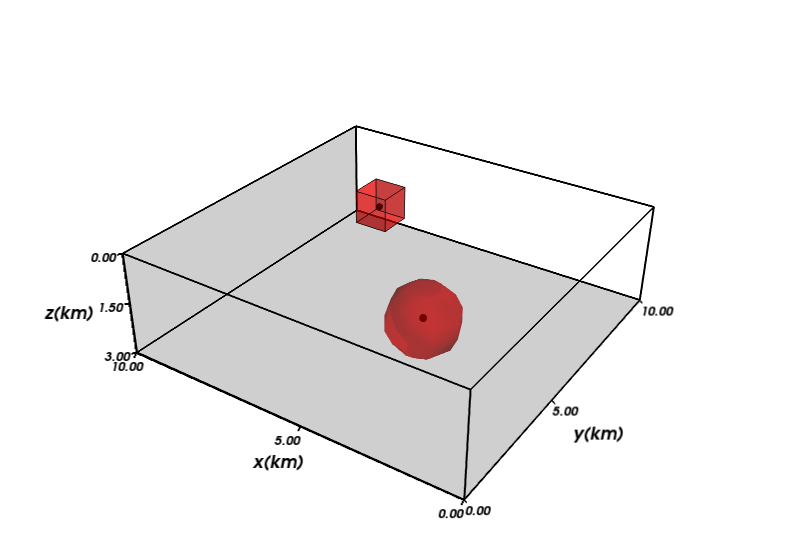

In [14]:
# Make noise-corrupted synthetic data
incs = [-20.0, 30.0]
decs = [-10.0, -40.0]
ints = [6.0, 6.0]
dipole = mesher.Sphere(3000, 3000, 1000, 1000, 
                       {'magnetization': ang2vec(ints[0], incs[0], decs[0])})
prism = mesher.Prism(6500, 7500, 6500, 7500, 200, 1200, 
                       {'magnetization': ang2vec(ints[1], incs[1], decs[1])})
area = [0, 10000, 0, 10000]
shape = (100,100)
x, y, z = gridder.regular(area, shape, z=-350)
tf = gravmag.sphere.tf(x, y, z, [dipole], inc, dec) + gravmag.prism.tf(x, y, z, [prism], inc, dec) + 50.0
uncertainty_data = 5.0 # nT
tf = contaminate(tf, uncertainty_data) # Gaussian noise with zero mean and standard deviation 5.0 nT

# Estimate the centers with Euler deconvolution
xderiv = gravmag.fourier.derivx(x, y, tf, shape)
yderiv = gravmag.fourier.derivy(x, y, tf, shape)
zderiv = gravmag.fourier.derivz(x, y, tf, shape)
#mpl.figure()
#mpl.suptitle('Pick the centers of the expanding windows')
#mpl.axis('scaled')
#mpl.contourf(y, x, tf, shape, 50)
#mpl.colorbar()
#wcenters = mpl.pick_points(area, mpl.gca(), xy2ne=True)

wcenters = [[ 3483.26359833,  2892.25941423],
            [ 7222.80334728,  6971.75732218]]

euler = Classic(x, y, z, tf, xderiv, yderiv, zderiv, 3)
sizes = numpy.linspace(200, 3000, 30)
results = [ExpandingWindow(euler, c, sizes).fit() for c in wcenters]

scene = myv.figure(size=(800,600))
centers = [r.estimate_ for r in results]
myv.points(centers, size=100.)
myv.prisms([prism], linewidth=1, color=(1, 0, 0), opacity=0.5)
myv.points([[dipole.x, dipole.y, dipole.z]], color=(1, 0, 0), size=dipole.radius, opacity=0.5)
bounds = area + [0, 3000]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-8074.8174870455587, -15111.695190949795, -12802.708939521674]
scene.scene.camera.focal_point = [5000.0000000000173, 5000.0000000000218, 1500.0000000000127]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.2894571115937859, 0.42260310974121879, -0.85884875978535002]
scene.scene.camera.clipping_range = [14297.219095006843, 45154.738489868898]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('sph_cube_euler_regfield_L1.png')
myv.show()
Image(filename='sph_cube_euler_regfield_L1.png')

### This Figure shows the synthetic bodies (sphere and cube) and their estimated centers (black points).

In [15]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
for i in range(solver.ndipoles):
    print '%12.5e %12.5e' % (incs[i], decs[i])
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-2.00000e+01 -1.00000e+01
 3.00000e+01 -4.00000e+01
Estimated
-2.32506e+01 -7.23962e+00
 2.87006e+01 -4.17813e+01
Uncertainties
 5.27456e-04  1.90968e-03
 2.29664e-02  4.36998e-02


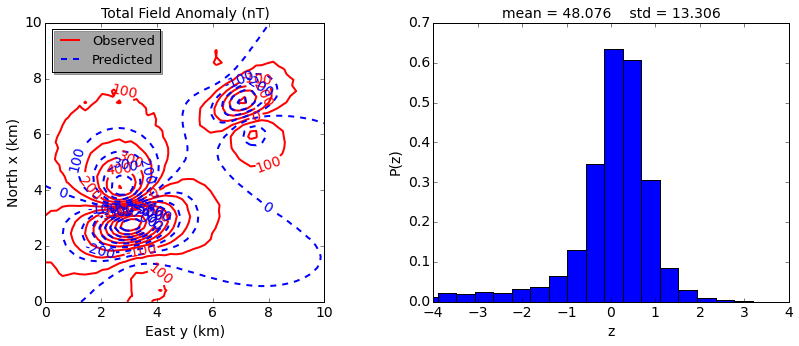

In [16]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('sph_cube_euler_regfield_L1_fit.png')
Image(filename='sph_cube_euler_regfield_L1_fit.png')
mpl.show()

## (Test L1-5) Estimation of the magnetization direction of a cube with estimated center. The center of the cube is estimated by using an Euler Deconvolution with [expanding window strategy](http://fatiando.readthedocs.org/en/latest/api/gravmag.euler.html#fatiando.gravmag.euler.ExpandingWindow)

### This test is similar to that one presented by Ellis, Wet and Macleod (2012).

References

* Ellis, R. G., B. Wet and I. N. Macleod, 2012, Inversion of magnetic data from 
    remanent and induced sources: 22nd International geophysical conference and 
    exhibition, ASEG, Expanded Abrastracts, 1-4, [link](http://www.geosoft.com/media/uploads/resources/technical-papers/magnetization_vector_inversion_mvi.pdf).

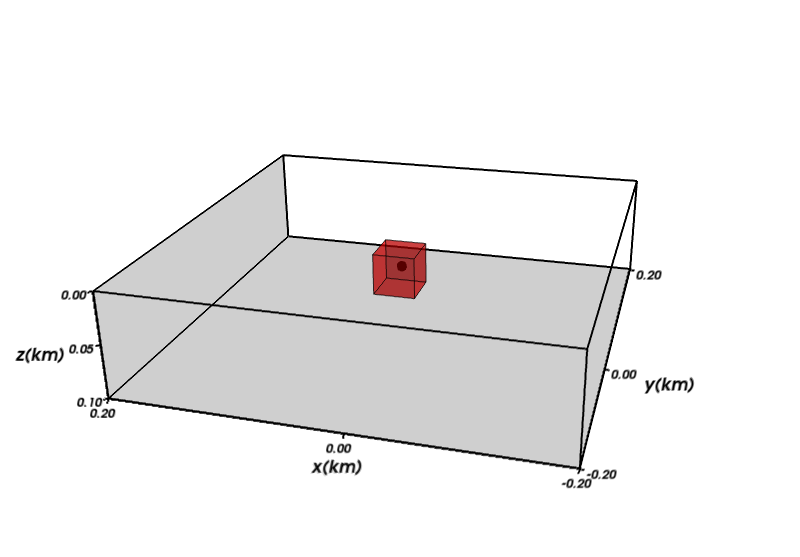

In [17]:
# Make synthetic data
inc, dec = 90.0, 0.0 # [º, º] inclination and declination of the Geomagnetic Field
incs = 0.0
decs = 90.0
ints = 0.5
prism = mesher.Prism(-20.0, 20.0, -20.0, 20.0, 20.0, 60.0, 
                       {'magnetization': ang2vec(ints, incs, decs)})

area = (-200.0, 200.0, -200.0, 200.0)
shape = (51,51)
x, y, z = gridder.regular(area, shape, z=-20.0)
tf = gravmag.prism.tf(x, y, z, [prism], inc, dec)
uncertainty_data = 0.3 #nT
tf = contaminate(tf, uncertainty_data) # Gaussian noise with zero mean and standard deviation 5.0 nT

# Estimate the centers with Euler deconvolution
xderiv = gravmag.fourier.derivx(x, y, tf, shape)
yderiv = gravmag.fourier.derivy(x, y, tf, shape)
zderiv = gravmag.fourier.derivz(x, y, tf, shape)
#mpl.figure()
#mpl.suptitle('Pick the centers of the expanding windows')
#mpl.axis('scaled')
#mpl.contourf(y, x, tf, shape, 50)
#mpl.colorbar()
#wcenters = mpl.pick_points(area, mpl.gca(), xy2ne=True)

wcenters = [[-1.0460251 , -0.62761506]]

euler = Classic(x, y, z, tf, xderiv, yderiv, zderiv, 3)
sizes = numpy.linspace(100.0, 400.0, 20)
results = [ExpandingWindow(euler, c, sizes).fit() for c in wcenters]

scene = myv.figure(size=(800,600))
centers = [r.estimate_ for r in results]
myv.points(centers, size=5.)
myv.prisms([prism], linewidth=1, color=(1, 0, 0), opacity=0.5)
bounds = [-200.0, 200.0, -200.0, 200.0, 0, 100.0]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-267.8737443835725, -867.74633060349845, -338.76304303233178]
scene.scene.camera.focal_point = [0.0, 0.0, 50.0]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.099767967744277153, 0.3810051162737364, -0.91917433274945937]
scene.scene.camera.clipping_range = [481.29996187584788, 1627.9082131268697]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('ellis2012_L1.png')
myv.show()
Image(filename='ellis2012_L1.png')

In [18]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
print '%12.5e %12.5e' % (incs, decs)
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
 0.00000e+00  9.00000e+01
Estimated
-6.90252e-01  9.00726e+01
Uncertainties
 2.92343e-02  5.25729e-02


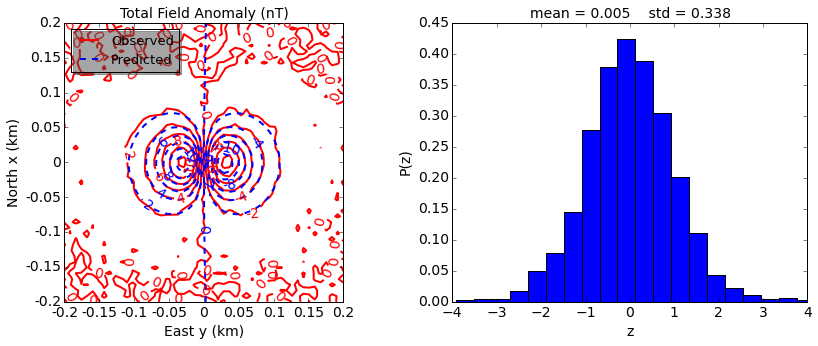

In [19]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('ellis2012_L1_fit.png')
Image(filename='ellis2012_L1_fit.png')
mpl.show()

## (Test L1-6) Estimation of the magnetization direction of two prisms with interfering anomalies

### This test is similar to that one presented by Lelièvre and Oldenburg (2009).

References

* Lelièvre, P. G. and D. Oldenburg, 2009, A 3D total magnetization inversion 
    applicable when significant, complicated remanence is present. Geophysics,
    74(3), L21–L30, doi: [10.1190/1.3103249](http://dx.doi.org/10.1190/1.3103249)

In [20]:
# Make synthetic data
inc, dec = -30.0, 0.0 # [º, º] inclination and declination of the Geomagnetic Field
inti = 3.0 # intensity of the induced magnetization
mi = ang2vec(inti, inc, dec)
incr1 = 0.0   # inclination of the remanent magnetization
decr1 = -30.0 # declination of the remanent magnetization
m1 = mi + ang2vec(3*inti, incr1, decr1) # total magnetization
ints1, incs1, decs1 = vec2ang(m1)
incr2 = 0.0   # inclination of the remanent magnetization
decr2 =  30.0 # declination of the remanent magnetization
m2 = mi + ang2vec(3*inti, incr2, decr2) # total magnetization
ints2, incs2, decs2 = vec2ang(m2)

In [21]:
print ints1, incs1, decs1
print ints2, incs2, decs2

11.4236596588 -7.54509258972 -23.4132244464
11.4236596588 -7.54509258972 23.4132244464


In [22]:
hg = numpy.cos(numpy.deg2rad(inc)) # horizontal component of the Geomagnetic Field
ht1 = numpy.cos(numpy.deg2rad(incs1)) # horizontal component of the magnetization vector
ht2 = numpy.cos(numpy.deg2rad(incs2)) # horizontal component of the magnetization vector

prism = [mesher.Prism(-40.0, 40.0, -40.0, -20.0, 10.0, 80.0, 
                       {'magnetization': m1}),
         mesher.Prism(-40.0, 40.0, 20.0, 40.0, 10.0, 80.0, 
                       {'magnetization': m2})]

area = (-200.0, 200.0, -200.0, 200.0)
shape = (51,51)
x, y, z = gridder.regular(area, shape, z=-10.0)
tf = gravmag.prism.tf(x, y, z, prism, inc, dec)
uncertainty_data = (numpy.max(tf) - numpy.min(tf))*0.02 #nT
tf = contaminate(tf, uncertainty_data) # Gaussian noise with zero mean and standard deviation 5.0 nT

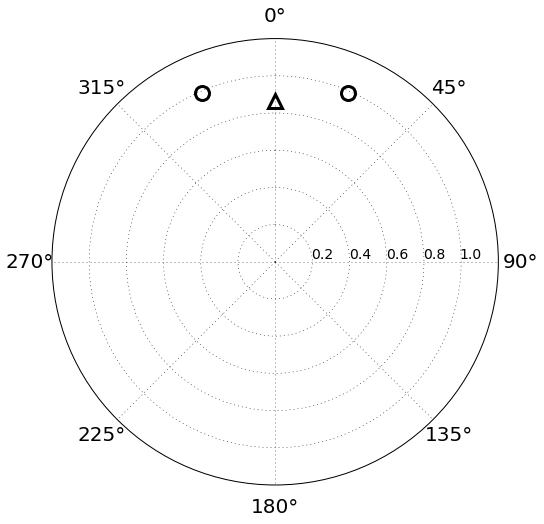

In [23]:
mpl.figure(figsize=(8,8))
ax = mpl.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_rgrids([0.2,0.4,0.6,0.8,1.0], angle=90.)
# direction of the Geomagnetic field
if inc >= 0.0:
    mpl.plot(numpy.deg2rad(dec), hg, marker='^', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(dec), hg, marker='^', ms=14, 
             mec='k', mew=3, fillstyle='none')
# true magnetization directions
if incs1 >= 0.0:
    mpl.plot(numpy.deg2rad(decs1), ht1, marker='o', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(decs1), ht1, marker='o', ms=14, 
             mec='k', mew=3, fillstyle='none')
if incs2 >= 0.0:
    mpl.plot(numpy.deg2rad(decs2), ht2, marker='o', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(decs2), ht2, marker='o', ms=14, 
             mec='k', mew=3, fillstyle='none')

mpl.xticks(fontsize=20) # on the cicle
mpl.yticks(fontsize=14) # along the radial direction
mpl.ylim(0.0, 1.2)
mpl.show()

### This figure is a stereographical projection of the directions of the geomagnetic field (open triangle) and true magnetization of the synthetic bodies (open-black circles). Open symbols indicate upper hemisphere and solid symbols indicate lower hemisphere.

c:\Anaconda\lib\site-packages\matplotlib\backends\backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)
c:\Anaconda\lib\site-packages\matplotlib\figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


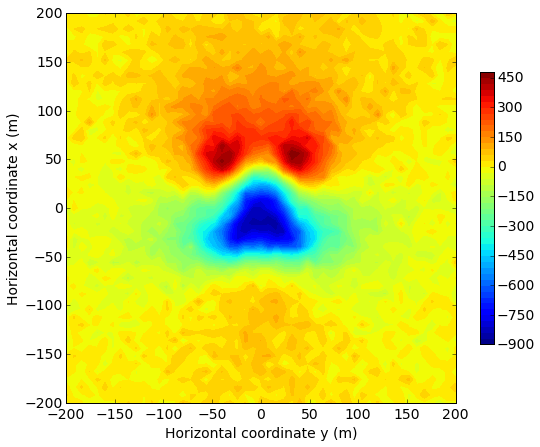

In [24]:
mpl.close('all')
mpl.figure(figsize=(8,8), tight_layout = True)
mpl.axis('scaled')
#mpl.title('Noise -corrupted total-field anomaly (nT)', fontsize=20)
mpl.contourf(y, x, tf, shape, 50)
mpl.colorbar(shrink = 0.5)
mpl.xlabel('Horizontal coordinate y (m)', fontsize=14)
mpl.ylabel('Horizontal coordinate x (m)', fontsize=14)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.savefig('lelievre2009_data_L1.png')
#Image(filename='lelievre2009_data_L1.png')
mpl.savefig('lelievre2009_data_L1.pdf', frameon=False, bbox_inches='tight')
mpl.show()

In [25]:
# Estimate the centers with Euler deconvolution
#xderiv = gravmag.fourier.derivx(x, y, tf, shape)
#yderiv = gravmag.fourier.derivy(x, y, tf, shape)
#zderiv = gravmag.fourier.derivz(x, y, tf, shape)
#mpl.figure()
#mpl.suptitle('Pick the centers of the expanding windows')
#mpl.axis('scaled')
#mpl.contourf(y, x, tf, shape, 50)
#mpl.colorbar()
#wcenters = mpl.pick_points(area, mpl.gca(), xy2ne=True)

#euler = Classic(x, y, z, tf, xderiv, yderiv, zderiv, 3)
#sizes = numpy.linspace(30.0, 150.0, 20)
#results = [ExpandingWindow(euler, c, sizes).fit() for c in wcenters]
#centers = [r.estimate_ for r in results]

In [26]:
estimates1 = []
estimates2 = []

### (Test L1-6a) Correct location of the centers of the synthetic bodies

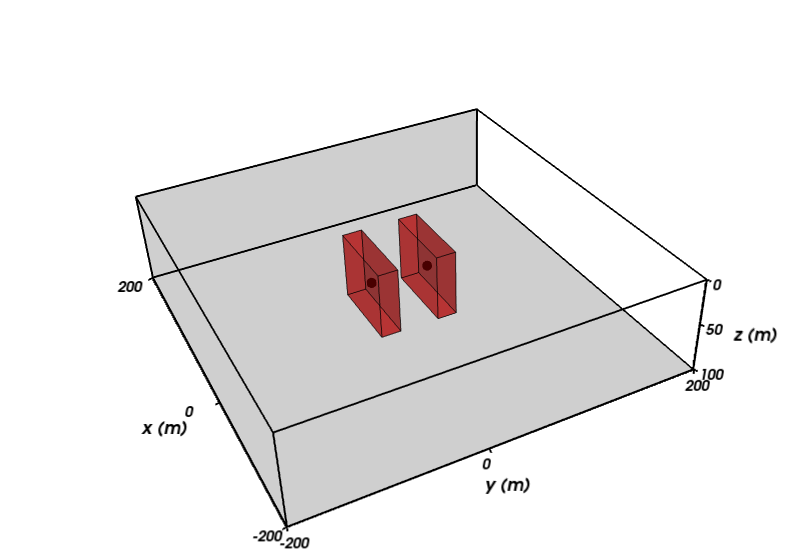

In [27]:
# True centers
centers = [[0, -30, 45], [0, 30, 45]]

scene = myv.figure(size=(800,600))
myv.points(centers, size=5.)
myv.prisms(prism, linewidth=1, color=(1, 0, 0), opacity=0.5)
bounds = [-200.0, 200.0, -200.0, 200.0, 0, 100.0]
#ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax = myv.axes(myv.outline(bounds), ranges=bounds, nlabels=3, fmt='%.0f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (m)', 'y (m)', 'z (m)'
ax.axes.font_factor = 1.3
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-756.93237775693171, -347.72353309061862, -518.26869202640387]
scene.scene.camera.focal_point = [-6.1604293011570419e-13, -6.1604293011570419e-14, 49.999999999999936]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.49097094136639891, 0.27963105374634795, -0.82507818327386351]
scene.scene.camera.clipping_range = [506.19272996401639, 1642.914773972215]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('lelievre2009_6a_L1.png')
myv.show()
Image(filename='lelievre2009_6a_L1.png')

### The dots pinpoint the correct positions of the centres of the sources.

In [28]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

estimates1.append(solver.estimate_[0])
estimates2.append(solver.estimate_[1])
    
# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
print '%12.5f %12.5f' % (incs1, decs1)
print '%12.5f %12.5f' % (incs2, decs2)
print 'Estimated'
for e in solver.estimate_:
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
    -7.54509    -23.41322
    -7.54509     23.41322
Estimated
   -11.12554    -22.27834
    -7.38531     25.27115
Uncertainties
     2.23104      1.59849
     1.49367      1.26431


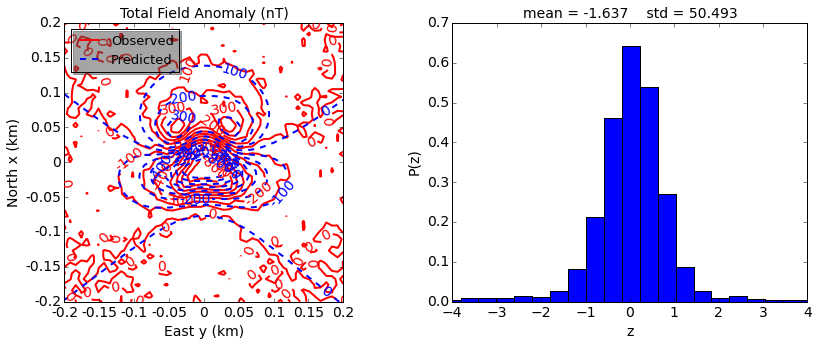

In [29]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('lelievre2009_6a_L1_fit.png')
Image(filename='lelievre2009_6a_L1_fit.png')
mpl.show()

### (Test L1-6b) Wrong location of the centers of the synthetic bodies

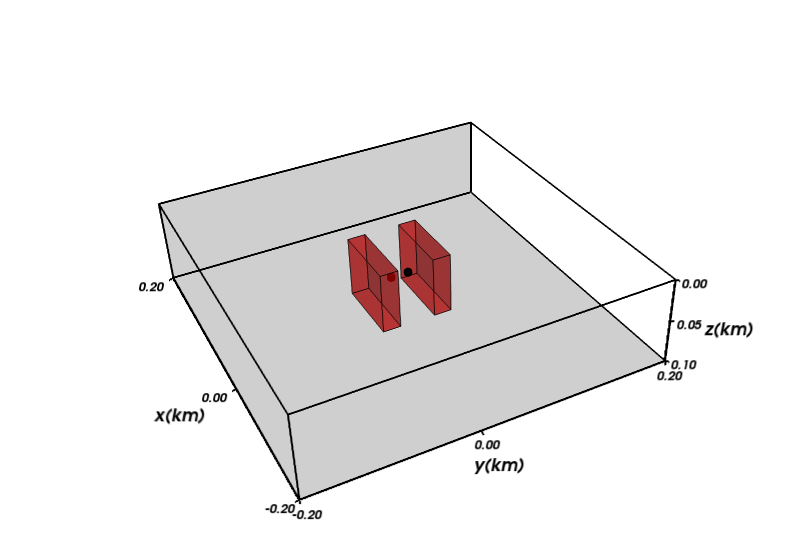

In [30]:
# Shifted centers along y (centers close to each other)
centers = [[0, -10, 45], [0, 10, 45]]

scene = myv.figure(size=(800,600))
myv.points(centers, size=5.)
myv.prisms(prism, linewidth=1, color=(1, 0, 0), opacity=0.5)
bounds = [-200.0, 200.0, -200.0, 200.0, 0, 100.0]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-833.05314552919367, -382.69228735342205, -575.41653033948512]
scene.scene.camera.focal_point = [0.0, 0.0, 50.0]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.49097094136639902, 0.279631053746348, -0.82507818327386373]
scene.scene.camera.clipping_range = [606.58410200933599, 1745.8412816752448]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('lelievre2009_6b_L1.png')
myv.show()
Image(filename='lelievre2009_6b_L1.png')

### The dots pinpoint the wrong positions of the centres of the sources.

In [31]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

estimates1.append(solver.estimate_[0])
estimates2.append(solver.estimate_[1])
    
# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
print '%12.5e %12.5e' % (incs1, decs1)
print '%12.5e %12.5e' % (incs2, decs2)
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-7.54509e+00 -2.34132e+01
-7.54509e+00  2.34132e+01
Estimated
-6.44505e+00 -5.55857e+01
-5.63698e+00  5.70268e+01
Uncertainties
 7.14098e-01  1.28270e-01
 8.45043e-01  3.58147e-01


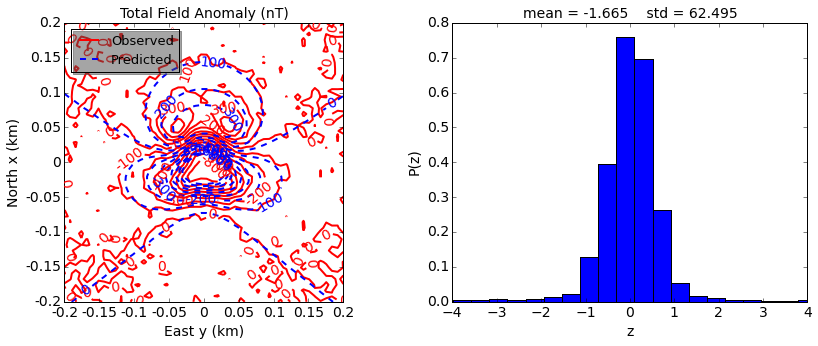

In [32]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('lelievre2009_6b_L1_fit.png')
Image(filename='lelievre2009_6b_L1_fit.png')
mpl.show()

### (Test L1-6c) Wrong location of the centers of the synthetic bodies

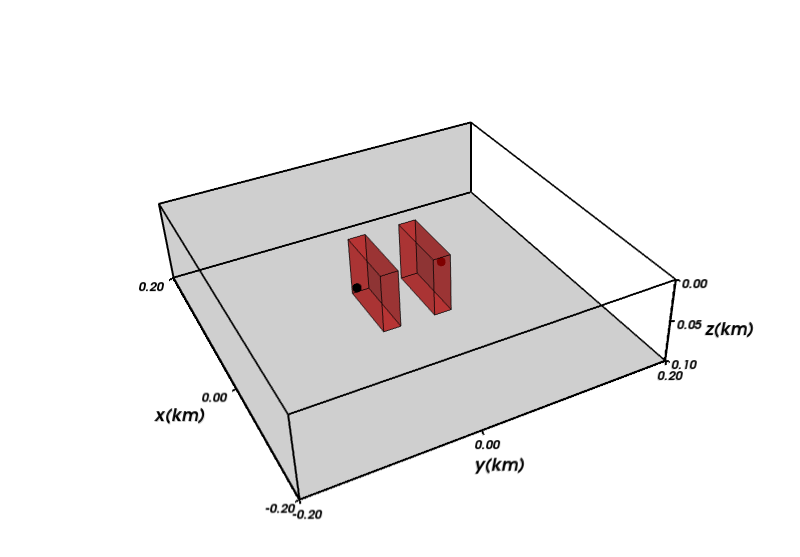

In [33]:
# Shifted centers along y (centers far from each other)
centers = [[0, -50, 45], [0, 50, 45]]

scene = myv.figure(size=(800,600))
myv.points(centers, size=5.)
myv.prisms(prism, linewidth=1, color=(1, 0, 0), opacity=0.5)
bounds = [-200.0, 200.0, -200.0, 200.0, 0, 100.0]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-833.05314552919367, -382.69228735342205, -575.41653033948512]
scene.scene.camera.focal_point = [0.0, 0.0, 50.0]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.49097094136639902, 0.279631053746348, -0.82507818327386373]
scene.scene.camera.clipping_range = [606.58410200933599, 1745.8412816752448]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('lelievre2009_6c_L1.png')
myv.show()
Image(filename='lelievre2009_6c_L1.png')

### The dots pinpoint the wrong positions of the centres of the sources.

In [34]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()
    
estimates1.append(solver.estimate_[0])
estimates2.append(solver.estimate_[1])

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
print '%12.5e %12.5e' % (incs1, decs1)
print '%12.5e %12.5e' % (incs2, decs2)
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-7.54509e+00 -2.34132e+01
-7.54509e+00  2.34132e+01
Estimated
-9.61223e+00 -7.20358e+00
-8.77719e+00  9.82640e+00
Uncertainties
 1.23837e-03  1.37879e-02
 3.51904e-02  1.17422e-01


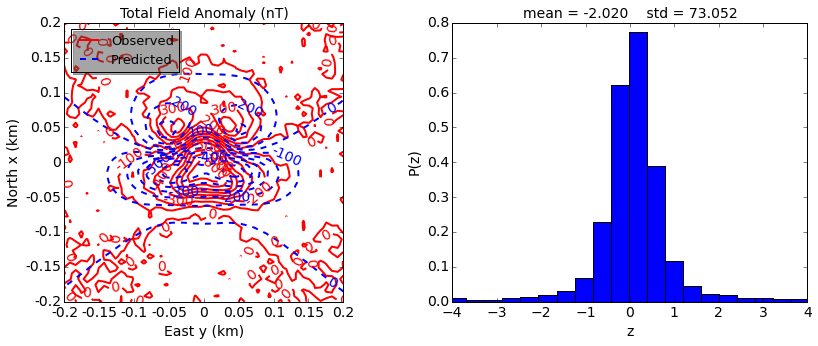

In [35]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('lelievre2009_6c_L1_fit.png')
Image(filename='lelievre2009_6c_L1_fit.png')
mpl.show()

### (Test L1-6d) Wrong location of the centers of the synthetic bodies

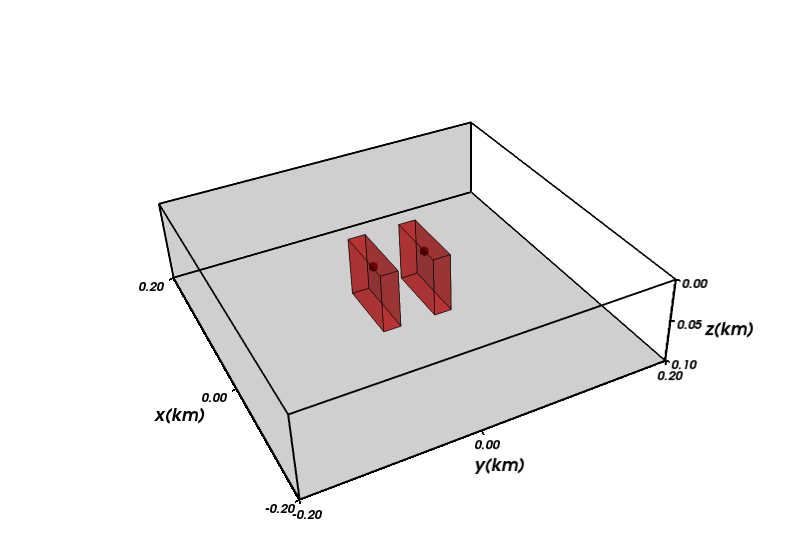

In [36]:
# Upward shifted centers
centers = [[0, -30, 25], [0, 30, 25]]

scene = myv.figure(size=(800,600))
myv.points(centers, size=5.)
myv.prisms(prism, linewidth=1, color=(1, 0, 0), opacity=0.5)
bounds = [-200.0, 200.0, -200.0, 200.0, 0, 100.0]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-833.05314552919367, -382.69228735342205, -575.41653033948512]
scene.scene.camera.focal_point = [0.0, 0.0, 50.0]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.49097094136639902, 0.279631053746348, -0.82507818327386373]
scene.scene.camera.clipping_range = [606.58410200933599, 1745.8412816752448]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('lelievre2009_6d_L1.png')
myv.show()
Image(filename='lelievre2009_6d_L1.png')

### The dots pinpoint the wrong positions of the centres of the sources.

In [37]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

estimates1.append(solver.estimate_[0])
estimates2.append(solver.estimate_[1])

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
print '%12.5e %12.5e' % (incs1, decs1)
print '%12.5e %12.5e' % (incs2, decs2)
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-7.54509e+00 -2.34132e+01
-7.54509e+00  2.34132e+01
Estimated
-1.12360e+01 -1.91211e+01
-8.86590e+00  1.95098e+01
Uncertainties
 4.62578e-03  1.48488e-02
 6.80131e-02  1.21856e-01


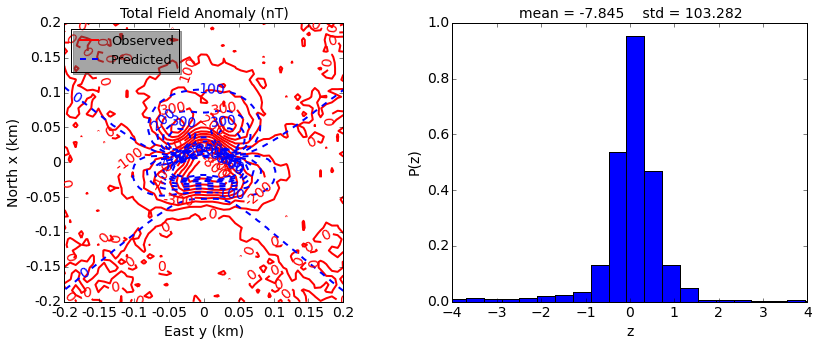

In [38]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('lelievre2009_6d_L1_fit.png')
Image(filename='lelievre2009_6d_L1_fit.png')
mpl.show()

### (Test L1-6e) Wrong location of the centers of the synthetic bodies

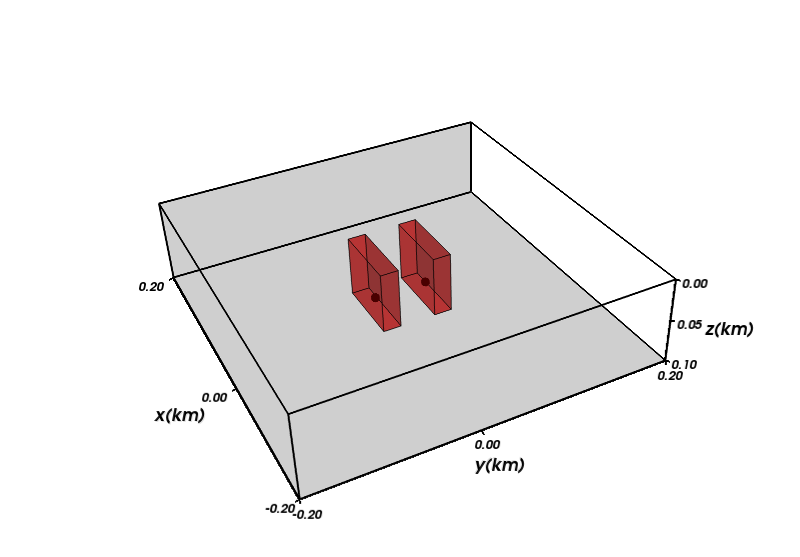

In [39]:
# Downward shifted centers
centers = [[0, -30, 65], [0, 30, 65]]

scene = myv.figure(size=(800,600))
myv.points(centers, size=5.)
myv.prisms(prism, linewidth=1, color=(1, 0, 0), opacity=0.5)
bounds = [-200.0, 200.0, -200.0, 200.0, 0, 100.0]
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.2f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x(km)', 'y(km)', 'z(km)'
ax.axes.font_factor = 1.2
myv.wall_bottom(bounds)
myv.wall_north(bounds)
scene.scene.camera.position = [-833.05314552919367, -382.69228735342205, -575.41653033948512]
scene.scene.camera.focal_point = [0.0, 0.0, 50.0]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.49097094136639902, 0.279631053746348, -0.82507818327386373]
scene.scene.camera.clipping_range = [606.58410200933599, 1745.8412816752448]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('lelievre2009_6e_L1.png')
myv.show()
Image(filename='lelievre2009_6e_L1.png')

### The dots pinpoint the wrong positions of the centres of the sources.

In [40]:
# Estimate the magnetization vectors
solver = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit() # L2-norm estimate
for i in range(100):
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver.set_weights(w)
    solver.fit()

estimates1.append(solver.estimate_[0])
estimates2.append(solver.estimate_[1])

# Calculate the uncertainties
dh = uncertainty_L1(uncertainty_data, solver)

# Print the estimated and true inclinations and declinations
print 'Comparison between the true and estimated parameters'
print 'inclination (first colunm) and declination (second colunm)'
print 'True'
print '%12.5e %12.5e' % (incs1, decs1)
print '%12.5e %12.5e' % (incs2, decs2)
print 'Estimated'
for e in solver.estimate_:
    print '%12.5e %12.5e' % (e[1], e[2])
print 'Uncertainties'
for dhj in dh:
    print '%12.5e %12.5e' % (dhj[1], dhj[2])

Comparison between the true and estimated parameters
inclination (first colunm) and declination (second colunm)
True
-7.54509e+00 -2.34132e+01
-7.54509e+00  2.34132e+01
Estimated
-7.26034e+00 -2.94604e+01
-5.53772e+00  3.17923e+01
Uncertainties
 1.24427e-02  1.25473e-02
 1.11547e-01  1.12015e-01


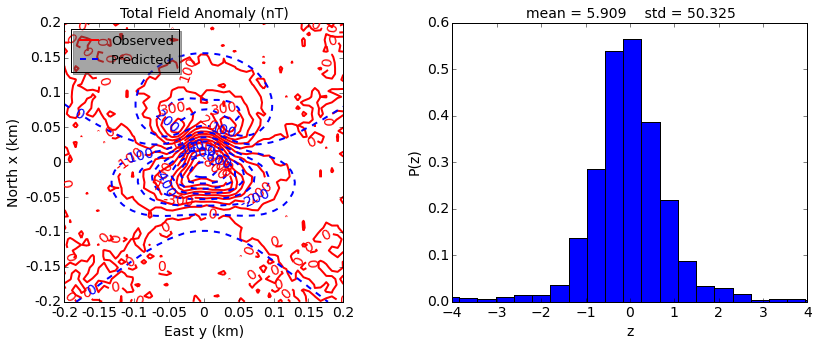

In [41]:
# Plot the fit and the normalized histogram of the residuals
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("Total Field Anomaly (nT)", fontsize = 14)
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.m2km()
mpl.subplot(1, 2, 2)
residuals_mean = numpy.mean(solver.residuals())
residuals_std = numpy.std(solver.residuals())
s = (solver.residuals() - residuals_mean)/residuals_std
smin = min(s)
smax = max(s)
nbins = ((smax - smin)/0.4)
mpl.hist(s, bins=nbins, range=None, normed=True, weights=None,
         cumulative=False, bottom=None, histtype='bar', align='mid',
         orientation='vertical', rwidth=None, log=False,
         color=None, label=None)
mpl.xlim(-4, 4)
mpl.title("mean = %.3f    std = %.3f" % (residuals_mean, residuals_std), fontsize = 14)
mpl.ylabel("P(z)", fontsize = 14)
mpl.xlabel("z", fontsize = 14)
mpl.savefig('lelievre2009_6e_L1_fit.png')
Image(filename='lelievre2009_6e_L1_fit.png')
mpl.show()

### Comparison between all results obtained in test L1-6

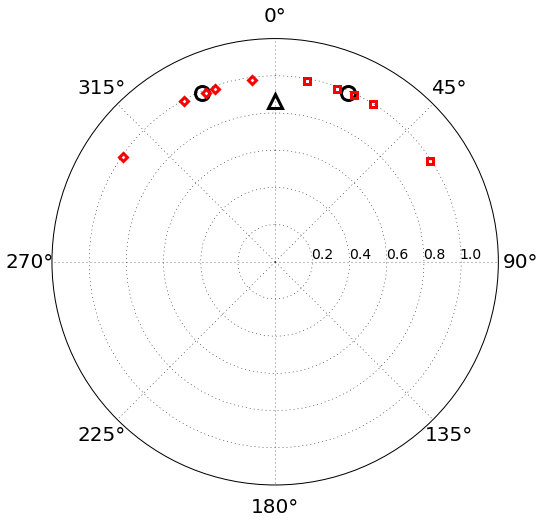

In [42]:
mpl.figure(figsize=(8,8))
ax = mpl.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_rgrids([0.2,0.4,0.6,0.8,1.0], angle=90.)
# direction of the Geomagnetic field
if inc >= 0.0:
    mpl.plot(numpy.deg2rad(dec), hg, marker='^', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(dec), hg, marker='^', ms=14, 
             mec='k', mew=3, fillstyle='none')
# true magnetization directions
if incs1 >= 0.0:
    mpl.plot(numpy.deg2rad(decs1), ht1, marker='o', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(decs1), ht1, marker='o', ms=14, 
             mec='k', mew=3, fillstyle='none')
if incs2 >= 0.0:
    mpl.plot(numpy.deg2rad(decs2), ht2, marker='o', ms=14, 
             mec='k', mew=3, mfc='k', fillstyle='full')
else:
    mpl.plot(numpy.deg2rad(decs2), ht2, marker='o', ms=14, 
             mec='k', mew=3, fillstyle='none')
# L1-norm estimates
for i, e in enumerate(estimates1):
    he = numpy.sqrt((numpy.cos(numpy.deg2rad(e[1]))*numpy.cos(numpy.deg2rad(e[2])))**2 + \
                    (numpy.cos(numpy.deg2rad(e[1]))*numpy.sin(numpy.deg2rad(e[2])))**2)
    if e[1] >= 0.0:
        mpl.plot(numpy.deg2rad(e[2]), he, marker='D', ms=6, 
             mec='r', mew=3, mfc='r', fillstyle='full')
    else:
        mpl.plot(numpy.deg2rad(e[2]), he, marker='D', ms=6, 
             mec='r', mew=3, fillstyle='none')
for i, e in enumerate(estimates2):
    he = numpy.sqrt((numpy.cos(numpy.deg2rad(e[1]))*numpy.cos(numpy.deg2rad(e[2])))**2 + \
                    (numpy.cos(numpy.deg2rad(e[1]))*numpy.sin(numpy.deg2rad(e[2])))**2)
    if e[1] >= 0.0:
        mpl.plot(numpy.deg2rad(e[2]), he, marker='s', ms=6, 
             mec='r', mew=3, mfc='r', fillstyle='full')
    else:
        mpl.plot(numpy.deg2rad(e[2]), he, marker='s', ms=6, 
             mec='r', mew=3, fillstyle='none')
mpl.xticks(fontsize=20) # on the cicle
mpl.yticks(fontsize=14) # along the radial direction
mpl.ylim(0.0, 1.2)
mpl.show()

### This figure is a stereographical projection of the directions of the geomagnetic field (open triangle), true magnetization of the synthetic bodies (open-black circles) and the robust-squares estimates (red-blue diamonds and squares) of the magnetization direction of the sources. Open symbols indicate upper hemisphere and solid symbols indicate lower hemisphere.

In [43]:
tests = ['L1-6a', 'L1-6b', 'L1-6c', 'L1-6d', 'L1-6e']

print 'True magnetization direction (source 1)'
print '%10.3f %10.3f' % (incs1,decs1)
print 'Estimated magnetization direction (source 1)'
print '       inc        dec       test'
for i, e in enumerate(estimates1):
    print '%10.3f %10.3f %10s' % (e[1],e[2], tests[i])
print 'True magnetization direction (source 2)'
print '%10.3f %10.3f' % (incs2,decs2)
print 'Estimated magnetization direction (source 2)'
print '       inc        dec       test'
for i, e in enumerate(estimates2):
    print '%10.3f %10.3f %10s' % (e[1],e[2],tests[i])

True magnetization direction (source 1)
    -7.545    -23.413
Estimated magnetization direction (source 1)
       inc        dec       test
   -11.126    -22.278      L1-6a
    -6.445    -55.586      L1-6b
    -9.612     -7.204      L1-6c
   -11.236    -19.121      L1-6d
    -7.260    -29.460      L1-6e
True magnetization direction (source 2)
    -7.545     23.413
Estimated magnetization direction (source 2)
       inc        dec       test
    -7.385     25.271      L1-6a
    -5.637     57.027      L1-6b
    -8.777      9.826      L1-6c
    -8.866     19.510      L1-6d
    -5.538     31.792      L1-6e


This synthetic test L1-6 is similar to the one produced by Lelièvre and Oldenburg (2009). In this test, we used different locations of the centres of the sources. These centres are pinpointed (dots) in the figures showing the prismatic sources (tests L1-6a-e). The stereographic projections of the estimates obtained by presuming different positions of the centres (Tests L1-6a-e)  show that the inclinations are better estimated than the declinations. Note that the worst estimates of the declinations (Tests L1-6 b and c) were obtained with errors in the horizontal locations of the centres of the prismatic sources. These results also show that our method is less sensitive to errors in the depths of the centres of the sources (Tests L1-6 d and e).